## FaceSegLite: Model Building

### **Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cv2
import os
from skimage.draw import polygon

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device = {device}")

device = cpu


### **Dataset Loading**


First, we define utils function to be able to load the HuggingFace datasets correctly.

In [2]:
def load_yolo_format(file_path):
  """
  Loads a file in YOLO format and pads coordinates with zeros.

  Args:
    - file_path: path to the file to load.
  Returns:
    - objects: np array of objects in the image. Each object is represented as a
      tuple of (x1, y1, ..., xn, yn), padded with zeros if necessary.
  """
  with open(file_path, 'r') as f:
    lines = f.readlines()

  objects = []
  for line in lines:
    data = line.strip().split()
    class_index = int(data[0]) # We don't care about the class name because we work only with one class (face)
    coordinates = np.array(list(map(float, data[1:])))
    objects.append(coordinates)

  return objects

def segments_to_masks(normalized_segments, image_shape):
    """
    Convert multiple normalized segments to binary masks.

    Args:
        normalized_segments (list): List of normalized segments.
        image_shape (tuple): Shape of the original image.

    Returns:
        masks (numpy.ndarray): Binary masks with shape (n, w, h).
    """
    masks = np.zeros((len(normalized_segments), *image_shape), dtype=np.uint8)

    for i, segment in enumerate(normalized_segments):
        coords = np.array(segment).reshape(-1, 2)

        # Convert normalized coordinates back to original image coordinates
        coords[:, 0] *= image_shape[1]  # width
        coords[:, 1] *= image_shape[0]  # height

        # Ensure coordinates are within the image boundaries
        coords[:, 0] = np.clip(coords[:, 0], 0, image_shape[1] - 1)
        coords[:, 1] = np.clip(coords[:, 1], 0, image_shape[0] - 1)

        # Round to integers
        coords = np.round(coords).astype(int)

        # Create a polygon and fill it in the mask
        rr, cc = polygon(coords[:, 1], coords[:, 0], shape=image_shape)
        masks[i, rr, cc] = 1

    return masks

def found_directory(file_path, folders):
    """
    Finds the directory in which the file is located.

    Args:
        - file_path: path to the file to load.
        - folders: list of folders to look into.
    
    Returns:
        - folder: name of the folder in which the file is located.
    """
    for i, folder in enumerate(folders):
        file_id = file_path.split('_')[0]
        folder_id = folder.split('--')[0]
        if file_id == folder_id:
            return folders[i]
    raise ValueError(f"Folder {folders} not found in {file_path}")

Define a custom torch Dataset.

In [3]:
class FslDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Get the mask files
        self.mask_folder = os.path.join(root_dir, 'masks')
        self.mask_files = sorted(os.listdir(self.mask_folder))

        # Get the image files
        self.image_folder = os.path.join(root_dir, 'images')
        self.image_files = [os.path.join(self.image_folder, found_directory(file_path, os.listdir(self.image_folder)),
                file_path.replace('txt', 'jpg')) for file_path in self.mask_files]
        
        # Load the masks
        self.mask = [load_yolo_format(os.path.join(self.mask_folder, self.mask_files[idx])) for idx in range(len(self.mask_files))]

        # Convert segments to masks
        self.mask = [segments_to_masks(self.mask[idx], cv2.imread(self.image_files[idx]).shape[:-1]) for idx in range(len(self.mask_files))]

    def __len__(self):
        return len(self.mask_files)


    def __getitem__(self, idx):
        # Get the image
        image = cv2.imread(self.image_files[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get the masks
        masks = self.mask[idx]

        sample = {'image': image, 'masks': masks}

        if self.transform:
            #sample['image'] = self.transform(sample['image'])
            #sample['masks'] = self.transform(sample['masks'])
            sample = self.transform(sample)
        return sample


Visualize some sample from our dataset.

In [4]:
def get_unique_color(index):
    """
    Generates a unique RGB color for a given class index.

    Args:
        - index: class index
    
    Returns:
        - color: tuple of (R, G, B) values
    """
    np.random.seed(index) # For reproducibility
    return tuple(np.random.rand(3))

def plot_image_with_segmentation_mask(image, masks, title=None):
    """
    Plots an image with its segmentation mask.

    Args:
        - image (np array): image to plot.
        - masks: list of masks in the image. Each object is represented as (x1, y1, ..., xn, yn).
    """
    # Plot the image
    plt.imshow(image)

    # Plot the segmentation mask for each object with a unique color
    for index, coordinates in enumerate(masks):
        num_points = len(coordinates) // 2
        mask_points = np.array(coordinates).reshape((num_points, 2))
        mask_points *= np.array([image.shape[1], image.shape[0]])  # Convert normalized coordinates to pixels
        mask_points = mask_points.astype(int)

        # Draw a polygon for the segmentation mask
        color = get_unique_color(index)
        polygon = Polygon(mask_points, closed=True, edgecolor=color, facecolor='none', linewidth=2)
        plt.gca().add_patch(polygon)

        # Fill the polygon with a unique color
        plt.fill(mask_points[:, 0], mask_points[:, 1], color=color, alpha=0.3)

    # Show the plot
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def show_mask(mask, ax, random_color=False):
    """
    Plots a mask. (binary mask)

    Args:
        - mask: mask to plot.
        - ax: axis to plot on.
        - random_color: if True, the mask will be plotted with a random color.
    """
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [5]:
fsl_dataset = FslDataset(root_dir='../data/')

Sample 0
Sample 0


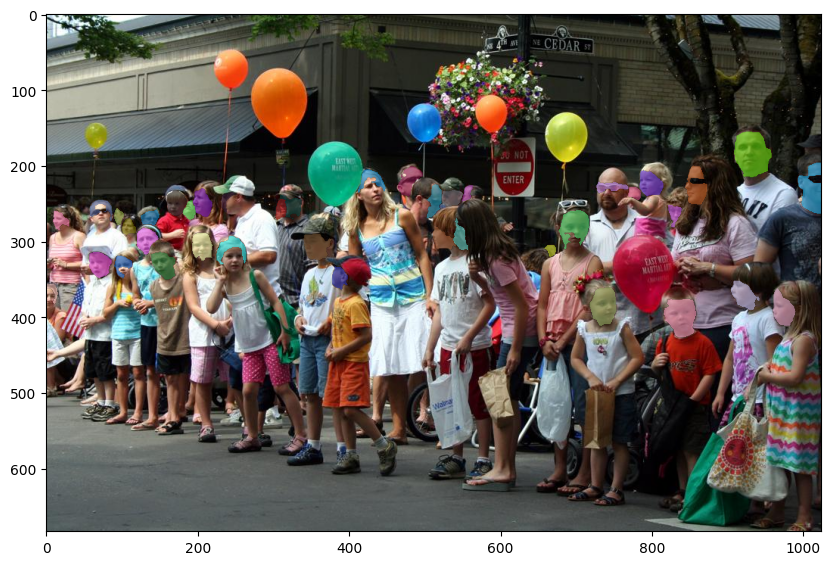

In [6]:
for i, sample in enumerate(fsl_dataset):
    if i == 1:
        break

    print(f"Sample {i}")
    plt.figure(figsize=(10,10))
    print(f"Sample {i}")
    plt.imshow(sample['image'])

    for mask in sample['masks']:
        show_mask(mask, plt.gca(), random_color=True)

### **Dataset Transformation**

TODO: Here we define the transformation for our dataset to be able to work efficiently for building our model

In [7]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, masks = sample['image'], sample['masks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        masks = np.array([transform.resize(mask, (new_h, new_w)) for mask in masks])

        return {'image': img, 'masks': masks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, masks = sample['image'], sample['masks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))


        # Pad the masks to have the same size
        # 50 is the max number of masks
        nb_of_pad = 50 - masks.shape[0]
        np.zeros((nb_of_pad, masks.shape[1], masks.shape[2]))
        padded_masks = np.concatenate((masks, np.zeros((nb_of_pad, masks.shape[1], masks.shape[2]))), axis=0)
        
        return {'image': torch.from_numpy(image),
                'masks': torch.from_numpy(padded_masks)}

In [8]:
#import torchvision.transforms as T


#transform = T.Compose([
    #ToPILImage(),
    #T.Resize((256, 256)),        # Resize to a fixed size
    #T.RandomHorizontalFlip(),    # Random horizontal flip
    #T.RandomVerticalFlip(),      # Random vertical flip
    #T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust brightness, contrast, and saturation
    #T.RandomRotation(degrees=15),  # Random rotation
    #T.ToTensor(),                # Convert to tensor
    #T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
#])

trans = transforms.Compose([Rescale((256, 256)), ToTensor()])


In [9]:

fsl_dataset = FslDataset(root_dir='../data/', transform=trans)
fsl_dataset_loader = DataLoader(fsl_dataset, batch_size=4, shuffle=True, num_workers=4)

In [11]:
"""for batch_idx, batch in enumerate(fsl_dataset_loader):
    if batch_idx == 1:
        break

    plt.figure(figsize=(15,10))
    # Iterate through samples in the batch
    for i in range(len(batch['image'])):
        sample = {'image': batch['image'][i], 'masks': batch['masks'][i]}

        print(f"Sample {sample['image'].shape}")
        print(f"Sample mask {sample['masks'].shape}")

        plt.subplot(1, len(batch['image']), i + 1)
        plt.imshow(sample['image'].permute(1, 2, 0))

        for mask in sample['masks']:
            if mask.sum() == 0:
                continue

            # Does not work idk why
            #show_mask(mask, plt.gca(), random_color=True)

            plt.imshow(mask, alpha=0.2)

    plt.show()"""


In [10]:
import cv2
import numpy as np

for batch_idx, batch in enumerate(fsl_dataset_loader):
    if batch_idx == 1:
        break

    plt.figure(figsize=(15,10))
    # Iterate through samples in the batch
    for i in range(len(batch['image'])):
        sample = {'image': batch['image'][i], 'masks': batch['masks'][i]}

        print(f"Sample {sample['image'].shape}")
        print(f"Sample mask {sample['masks'].shape}")

        plt.subplot(1, len(batch['image']), i + 1)
        img = sample['image'].permute(1, 2, 0)
        plt.imshow(img)

        for mask in sample['masks']:
            if mask.sum() == 0:
                continue

            # Convert mask to binary image
            _, binary_mask = cv2.threshold(mask, 0.5, 1, cv2.THRESH_BINARY)

            # Resize mask to match image dimensions
            binary_mask = cv2.resize(binary_mask, (img.shape[1], img.shape[0]))

            plt.imshow(binary_mask, alpha=0.2)

    plt.show()